In [1]:
%env MICROMAGE_DOUBLE=1
import micromage as mg
print(mg.dtype)
import numpy as np
import matplotlib.pyplot as plt
import rich

import jax_dataclasses as jdc
import jax
import jax.numpy as jnp

env: MICROMAGE_DOUBLE=1
<class 'jax.numpy.float64'>


In [2]:
@jdc.pytree_dataclass
class RollSystem(mg.System):
    roll_x: float = 0.

###############################################################################

@jax.jit
def roll_and_flip(nn, s:RollSystem):
    # Group vertices in the cell.
    ns = mg.pack3(mg.pack3(nn))

    sx, sy, sz = ns.shape[1:4]
    assert ns.shape==(3,sx,sy,sz,3,3), f"Wrong shape {ns.shape}"
    ax = s.Lx/sx/2 # Grid step along x-axis.
    ay = s.Ly/sy/2 # Grid step along y-axis.

    # Grid coordinates.
    xx, yy = mg.coordinates_xy(nn.shape[1], nn.shape[2], s)
    # Reflect grid
    xx = s.Lx - xx
    # Shift grid.
    xx = xx + s.roll_x
    # Apply BC.
    # xx = xx - jnp.floor(xx/s.Lx)*s.Lx

    # Interpolate the magnetization field to the shifted grid.
    mm = mg.interpolate3(ns, xx.flatten()/(2*ax), yy.flatten()/(2*ay))
    mm = mm.reshape(nn.shape)
    # Reflect magnitization.
    mm = mm * jnp.array([-1,1,-1])[:,None,None,None]

    return mm

@jax.jit
def roll_energy(nn, s:RollSystem):
    """
    The magnetization field should be given at `SIMPSON_P` points.
    """
    # Group vertices in the cell.
    ns = mg.pack3(mg.pack3(nn))

    sx, sy, sz = ns.shape[1:4]
    assert ns.shape==(3,sx,sy,sz,3,3), f"Wrong shape {ns.shape}"
    ax = s.Lx/sx/2 # Grid step along x-axis.
    ay = s.Ly/sy/2 # Grid step along y-axis.

    # Grid coordinates.
    xx, yy = mg.coordinates_xy(nn.shape[1], nn.shape[2], s)
    # Reflect grid
    xx = s.Lx - xx
    # Shift grid.
    xx = xx + s.roll_x
    # Apply BC.
    # xx = xx - jnp.floor(xx/s.Lx)*s.Lx

    # Interpolate the magnetization field to the shifted grid.
    mm = mg.interpolate3(ns, xx.flatten()/(2*ax), yy.flatten()/(2*ay))
    mm = mm.reshape(nn.shape)
    # Reflect magnitization.
    mm = mm * jnp.array([-1,1,-1])[:,None,None,None]

    ms = mg.pack3(mg.pack3(mm))

    # Interpolate to Gauss–Lobatto nodes. 
    n = mg.intp3(ns, x=mg.SIMPSON_P, y=mg.GL3_P, axis=-2)
    n = mg.intp3(n,  x=mg.SIMPSON_P, y=mg.GL3_P, axis=-1)

    m = mg.intp3(ms, x=mg.SIMPSON_P, y=mg.GL3_P, axis=-2)
    m = mg.intp3(m,  x=mg.SIMPSON_P, y=mg.GL3_P, axis=-1)

    # Compute all derivatives.
    ndx = mg.diff3(n, x=mg.GL3_P, y=mg.GL3_P, axis=-2)/ax
    ndy = mg.diff3(n, x=mg.GL3_P, y=mg.GL3_P, axis=-1)/ay

    rotx, roty, rotz = ndy[2], -ndx[2], ndx[1]-ndy[0]       
    divn = ndx[0]+ndy[1]

    # Compute contributons to energy.
    e_heisenberg_ra = s.A*jnp.sum(
        mg.quad_xy3(jnp.sum(ndx**2,axis=0))+
        mg.quad_xy3(jnp.sum(ndy**2,axis=0))
    )
    
    e_heisenberg_er = -s.J*jnp.sum(
        mg.quad_xy3(1+jnp.sum(n*m,axis=0))
    ) 
    
    e_dm_b = s.Db*jnp.sum(
        mg.quad_xy3(n[0]*rotx)+
        mg.quad_xy3(n[1]*roty)+
        mg.quad_xy3(n[2]*rotz)
    )

    e_dm_i = s.Di*jnp.sum(
        mg.quad_xy3(n[2]*divn)
        -mg.quad_xy3(n[0]*ndx[2])
        -mg.quad_xy3(n[1]*ndy[2])
    )
    
    e_ani = -s.K*jnp.sum(mg.quad_xy3(n[2]**2-1))
    
    e_zeeman = -s.H*jnp.sum(mg.quad_xy3(n[2]-1))

    e_imp = jnp.sum(s.imp_K[:,None]*mg.interpolate3(ns, s.imp_x/(2*ax), s.imp_y/(2*ay))[2]**2)
        
    return (e_heisenberg_ra + 
            e_heisenberg_er + 
            e_dm_b + e_dm_i + e_zeeman + e_ani) * (ax*ay) + e_imp

###############################################################################

class ComputerRoll(mg.Computer):
    def __init__(self, system: RollSystem):
        super().__init__(system=system, energy=roll_energy)

    def inner(self, n1, n2):
        return mg.inner3(n1, n2, self.system)

In [3]:
system = RollSystem(
    Lx=18, Ly=18, Db=2.5, K=4, H=0.,
    J=0., roll_x=0, #10*18/300,
    eta=0.2, jx=0, beta=0.,
)

print(system)

comp = ComputerRoll(system)
xy = comp.coordinates(300, 300)

a1 = mg.AnalyticA(system=system, xy=xy)

p0 = jnp.array([system.Lx/2, system.Ly/2+1e-6, 2.72306583, 0.49147274, -np.pi/2, 0, 0.0])
print(f"Initial parameters {p0}")
n0 = a1(p0)

# Test energy.
# roll_energy(n0, system)
print(f"Unrelaxed energy {comp.energy(n0)}")

# Test translations and reflection.
n = roll_and_flip(n0, system)
print(f"Reflected energy {comp.energy(n)}")
# mg.analyze_geometry(-n, xy, var=None);

print(f"Variation on reflection {np.max(np.abs(n0+n))}")

RollSystem(A=1, J=0.0, Db=2.5, Di=0, H=0.0, K=4, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0, imp_x=array([], dtype=float64), imp_y=array([], dtype=float64), imp_K=array([], dtype=float64), roll_x=0)
Initial parameters [ 9.          9.000001    2.72306583  0.49147274 -1.57079633  0.
  0.        ]
Unrelaxed energy 4.85886126780118
Reflected energy 4.858861270660313
Variation on reflection 1.5708378858996468e-06


Output()

0: E 4.859 dE 9.87e-02 2.20e-03 Step 5.00e-02 Beta 0.00e+00 PE -1.96e-10 SubSteps 1 NegSteps 0 FailedConv 0

20: E 4.820 dE 5.11e-02 1.02e-03 Step 5.00e-02 Beta 9.66e-01 PE 1.36e-02 SubSteps 1 NegSteps 0 FailedConv 0

40: E 4.803 dE 2.13e-02 3.97e-04 Step 5.00e-02 Beta 9.30e-01 PE 4.62e-03 SubSteps 1 NegSteps 0 FailedConv 0

60: E 4.800 dE 1.15e-02 2.12e-04 Step 5.00e-02 Beta 9.55e-01 PE 3.83e-04 SubSteps 1 NegSteps 0 FailedConv 0

80: E 4.799 dE 5.69e-03 7.72e-05 Step 5.00e-02 Beta 9.27e-01 PE 3.66e-04 SubSteps 1 NegSteps 0 FailedConv 0

100: E 4.798 dE 2.64e-03 2.27e-05 Step 5.00e-02 Beta 0.00e+00 PE 3.76e-06 SubSteps 1 NegSteps 0 FailedConv 0

120: E 4.798 dE 1.68e-03 1.29e-05 Step 5.00e-02 Beta 9.42e-01 PE 2.20e-05 SubSteps 1 NegSteps 0 FailedConv 0

140: E 4.798 dE 8.56e-04 7.93e-06 Step 5.00e-02 Beta 9.32e-01 PE 1.13e-05 SubSteps 1 NegSteps 0 FailedConv 0

160: E 4.798 dE 5.12e-04 4.61e-06 Step 5.00e-02 Beta 9.65e-01 PE 7.77e-07 SubSteps 1 NegSteps 0 FailedConv 0

180: E 4.798 dE 2.99e-04 2.31e-06 Step 5.00e-02 Beta 9.40e-01 PE 1.20e-06 SubSteps 1 NegSteps 0 FailedConv 0

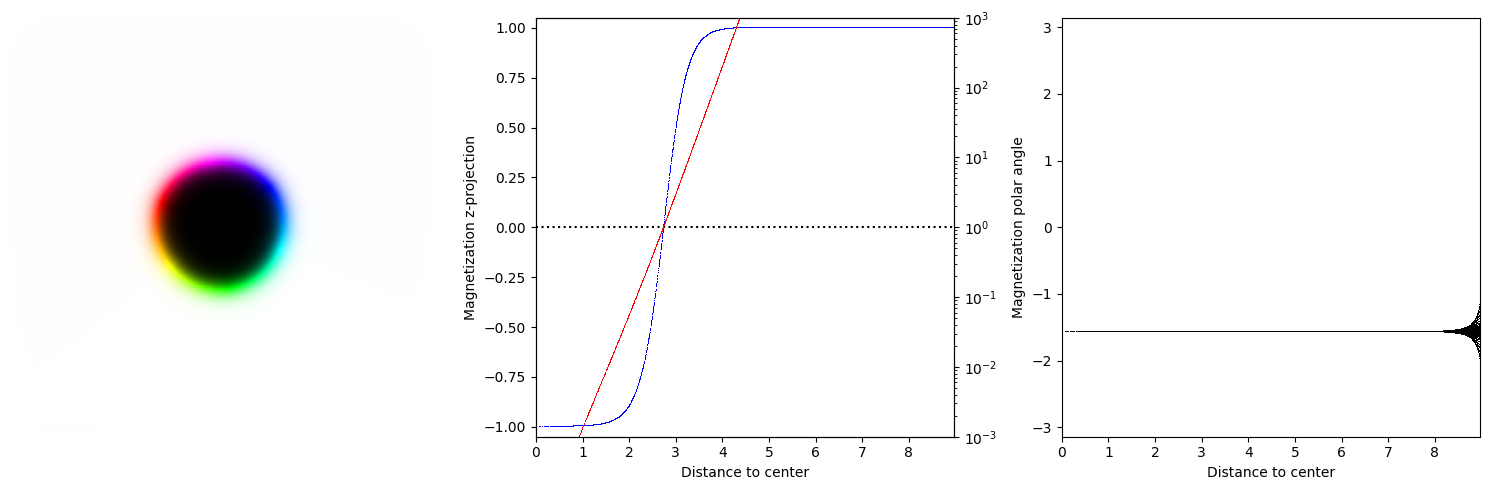

In [4]:
# Optimization of ferromagnetic skyrmion.
n = mg.ncg(n0, comp, maxiter=200, maxstep=0.05)
# n = mg.ncg(n, comp, maxiter=200, maxstep=0.05)
mg.analyze_geometry(n, xy, var=None);

In [5]:
comp.system = jdc.replace(comp.system, J=0., roll_x=0.)
print( f"J={comp.system.J} roll_x={comp.system.roll_x} Energy ", comp.energy(n) )
comp.system = jdc.replace(comp.system, J=-1., roll_x=0.1)
print( f"J={comp.system.J} roll_x={comp.system.roll_x} Energy ", comp.energy(n) )


J=0.0 roll_x=0.0 Energy  4.7983494906660065
J=-1.0 roll_x=0.1 Energy  4.978130496222175


Output()

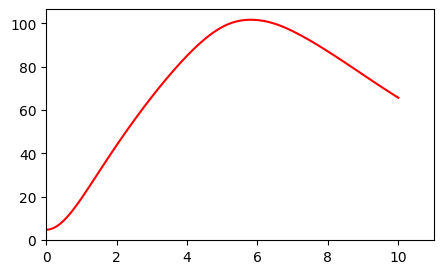

In [6]:
# rxs = np.linspace(-4, 4, 100)
rxs = np.linspace(0, 10, 100)

ens = np.empty_like(rxs)
for k, rx in rich.progress.track(enumerate(rxs)):
    comp.system = jdc.replace(comp.system, J=-1., roll_x=rx)
    ens[k] = comp.energy(n)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(rxs, ens, '-r')
ax.plot(-rxs, ens, '-b')
ax.set_xlim(0,None);

Output()

0: E 8.364 dE 3.75e-01 1.17e-02 Step 5.00e-02 Beta 0.00e+00 PE -1.12e-04 SubSteps 1 NegSteps 0 FailedConv 0

20: E 8.326 dE 6.72e-02 1.42e-03 Step 5.00e-02 Beta 1.14e+00 PE 3.77e-02 SubSteps 1 NegSteps 0 FailedConv 0

40: E 8.294 dE 3.63e-02 6.58e-04 Step 5.00e-02 Beta 9.12e-01 PE 3.60e-02 SubSteps 1 NegSteps 0 FailedConv 0

60: E 8.284 dE 2.46e-02 5.35e-04 Step 5.00e-02 Beta 1.03e+00 PE 2.28e-03 SubSteps 1 NegSteps 0 FailedConv 0

80: E 8.276 dE 2.25e-02 5.19e-04 Step 5.00e-02 Beta 1.02e+00 PE 1.82e-02 SubSteps 1 NegSteps 0 FailedConv 0

100: E 8.260 dE 2.43e-02 5.36e-04 Step 5.00e-02 Beta 0.00e+00 PE 1.10e-03 SubSteps 1 NegSteps 0 FailedConv 0

120: E 8.256 dE 2.10e-02 4.94e-04 Step 5.00e-02 Beta 9.99e-01 PE 7.31e-03 SubSteps 1 NegSteps 0 FailedConv 0

140: E 8.244 dE 2.22e-02 5.04e-04 Step 5.00e-02 Beta 1.01e+00 PE 3.84e-02 SubSteps 1 NegSteps 0 FailedConv 0

160: E 8.233 dE 2.06e-02 5.20e-04 Step 5.00e-02 Beta 1.00e+00 PE 1.33e-03 SubSteps 1 NegSteps 0 FailedConv 0

180: E 8.226 dE 2.08e-02 5.01e-04 Step 5.00e-02 Beta 1.01e+00 PE 1.74e-02 SubSteps 1 NegSteps 0 FailedConv 0

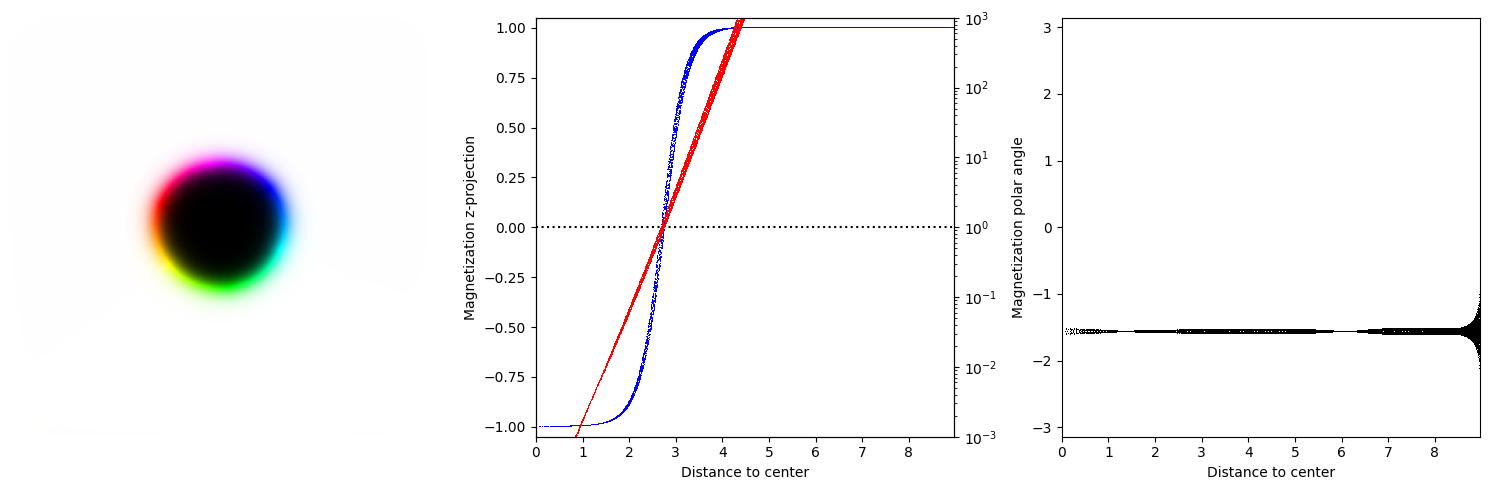

In [8]:
comp.system = jdc.replace(comp.system, J=-5., roll_x=0.2)
# n1 = mg.gradient_descent(n, comp, maxiter=100, step=0.1)
n1 = mg.ncg(n, comp, maxiter=200, tol=1e-4, maxstep=0.05, constraints=mg.constrain_translations)
mg.analyze_geometry(n1, xy, var=None);


Output()

0: E 4.798 dE 5.65e-04 9.50e-06 Step 5.00e-02 Beta 0.00e+00 PE -4.65e-11 SubSteps 1 NegSteps 0 FailedConv 0

29: E 4.798 dE 9.54e-05 Converged

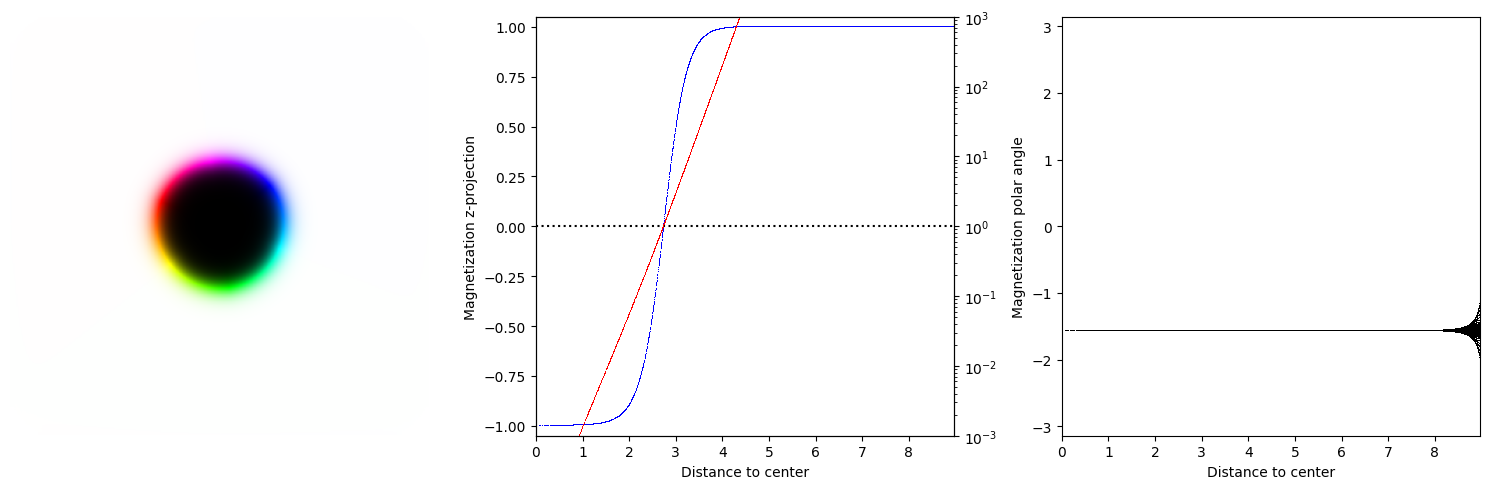

Output()

0: E 4.854 dE 1.34e-02 3.02e-04 Step 5.00e-02 Beta 0.00e+00 PE -3.60e-07 SubSteps 1 NegSteps 0 FailedConv 0

250: E 4.854 dE 3.60e-04 8.08e-06 Step 5.00e-02 Beta 0.00e+00 PE -2.26e-07 SubSteps 1 NegSteps 0 FailedConv 0

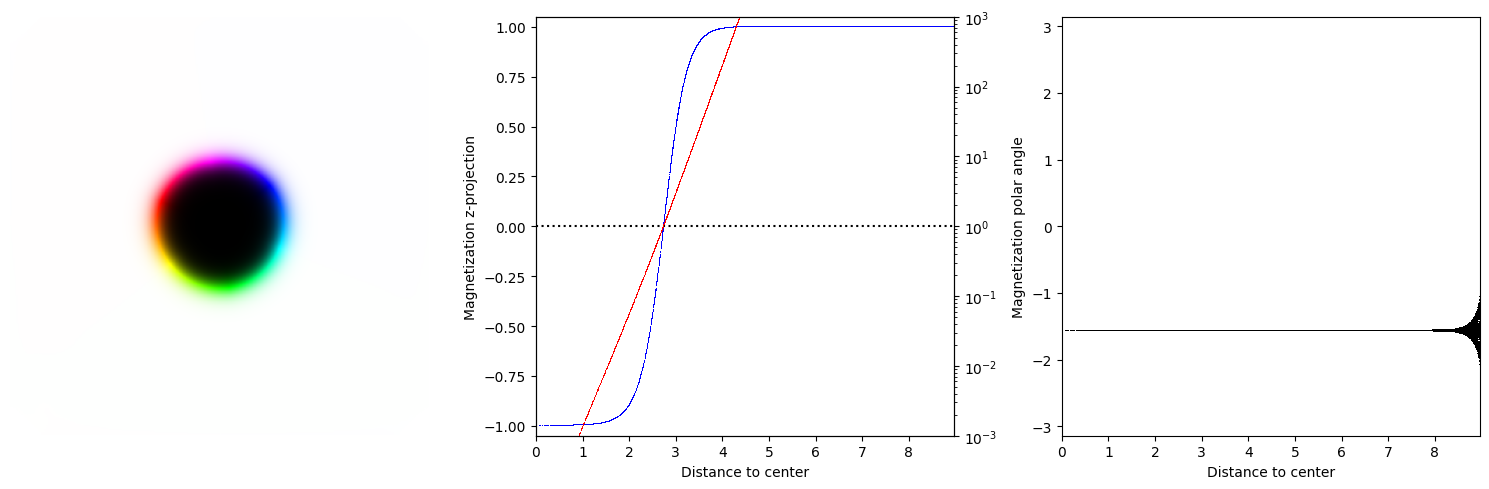

Output()

0: E 5.020 dE 3.68e-02 1.14e-03 Step 5.00e-02 Beta 0.00e+00 PE -1.42e-06 SubSteps 1 NegSteps 0 FailedConv 0

250: E 5.019 dE 1.29e-03 3.06e-05 Step 5.00e-02 Beta 0.00e+00 PE 4.98e-07 SubSteps 1 NegSteps 0 FailedConv 0

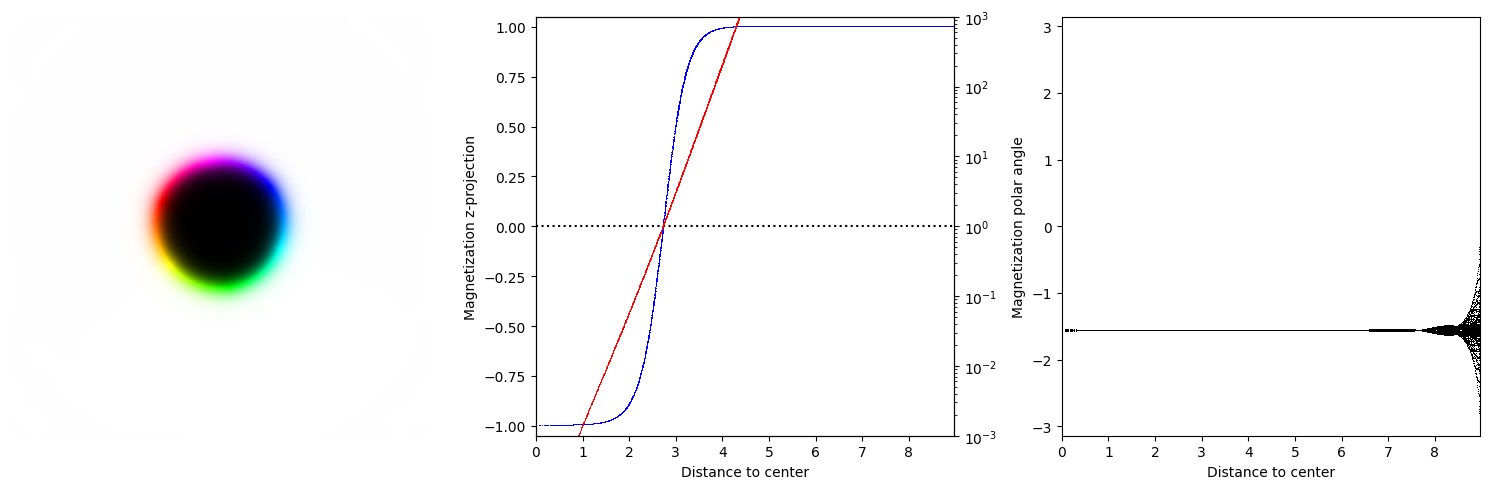

Output()

0: E 5.292 dE 1.75e-02 5.17e-04 Step 5.00e-02 Beta 0.00e+00 PE -3.10e-06 SubSteps 1 NegSteps 0 FailedConv 0

250: E 5.289 dE 2.79e-03 6.54e-05 Step 5.00e-02 Beta 0.00e+00 PE 5.78e-06 SubSteps 1 NegSteps 0 FailedConv 0

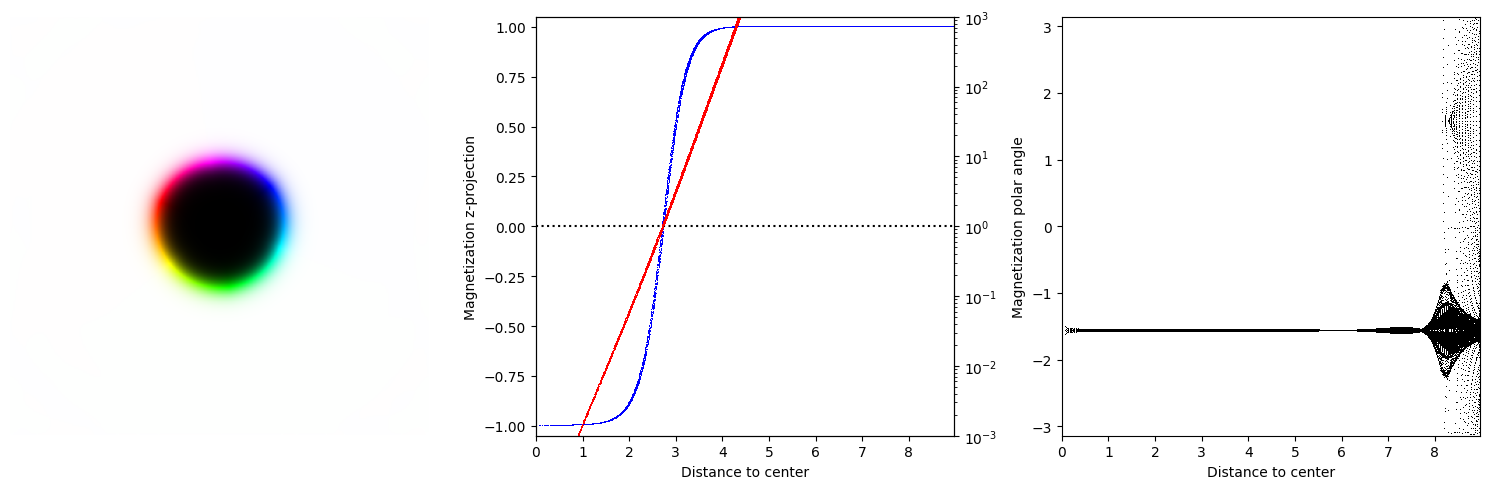

Output()

0: E 5.662 dE 5.31e-02 1.46e-03 Step 5.00e-02 Beta 0.00e+00 PE -5.27e-06 SubSteps 1 NegSteps 0 FailedConv 0

250: E 5.655 dE 4.63e-03 1.08e-04 Step 5.00e-02 Beta 0.00e+00 PE 1.93e-05 SubSteps 1 NegSteps 0 FailedConv 0

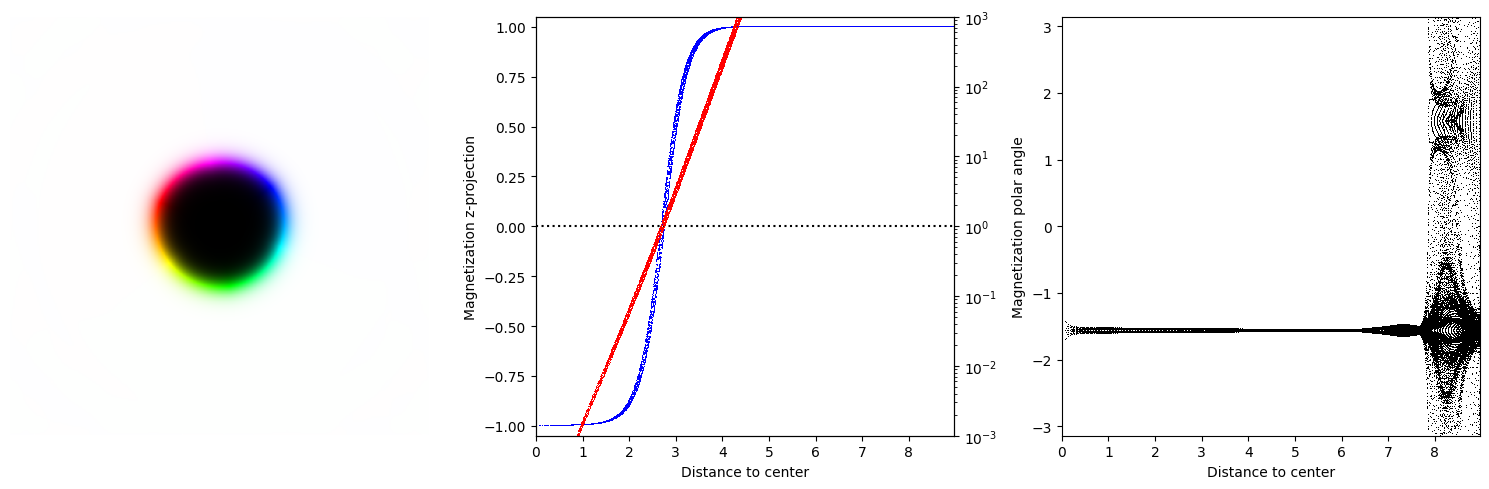

Output()

0: E 6.117 dE 1.90e-02 4.84e-04 Step 5.00e-02 Beta 0.00e+00 PE -7.73e-06 SubSteps 1 NegSteps 0 FailedConv 0

250: E 6.104 dE 6.95e-03 1.59e-04 Step 5.00e-02 Beta 0.00e+00 PE 4.52e-05 SubSteps 1 NegSteps 0 FailedConv 0

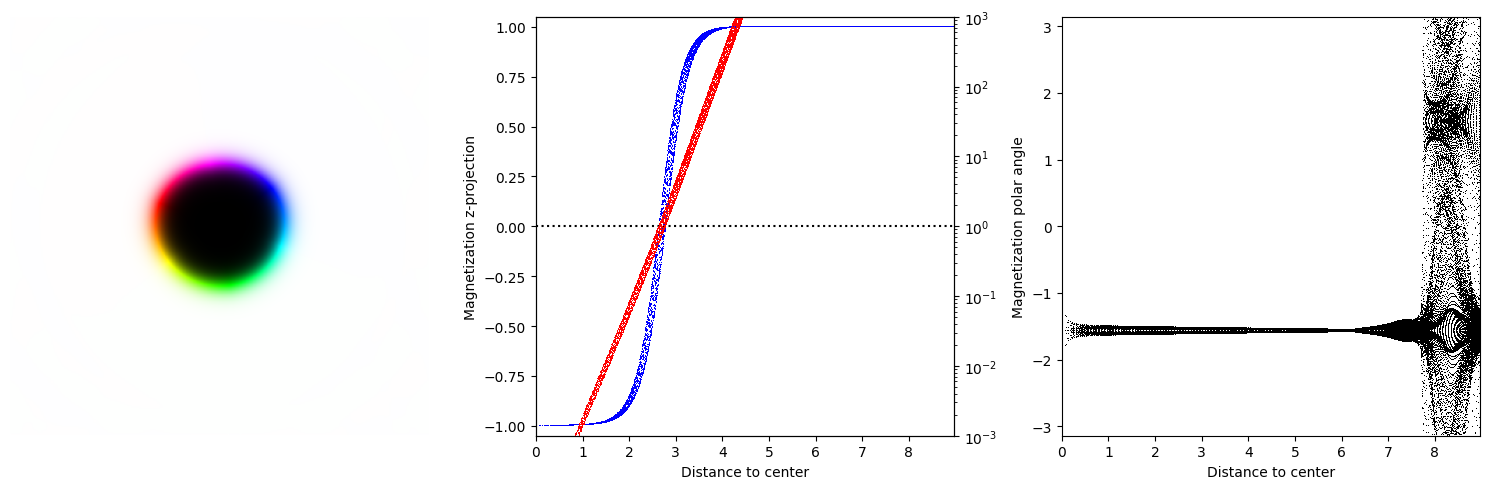

Output()

0: E 6.641 dE 4.57e-02 1.16e-03 Step 5.00e-02 Beta 0.00e+00 PE -1.03e-05 SubSteps 1 NegSteps 0 FailedConv 0

250: E 6.619 dE 9.21e-03 2.10e-04 Step 5.00e-02 Beta 0.00e+00 PE 8.21e-05 SubSteps 1 NegSteps 0 FailedConv 0

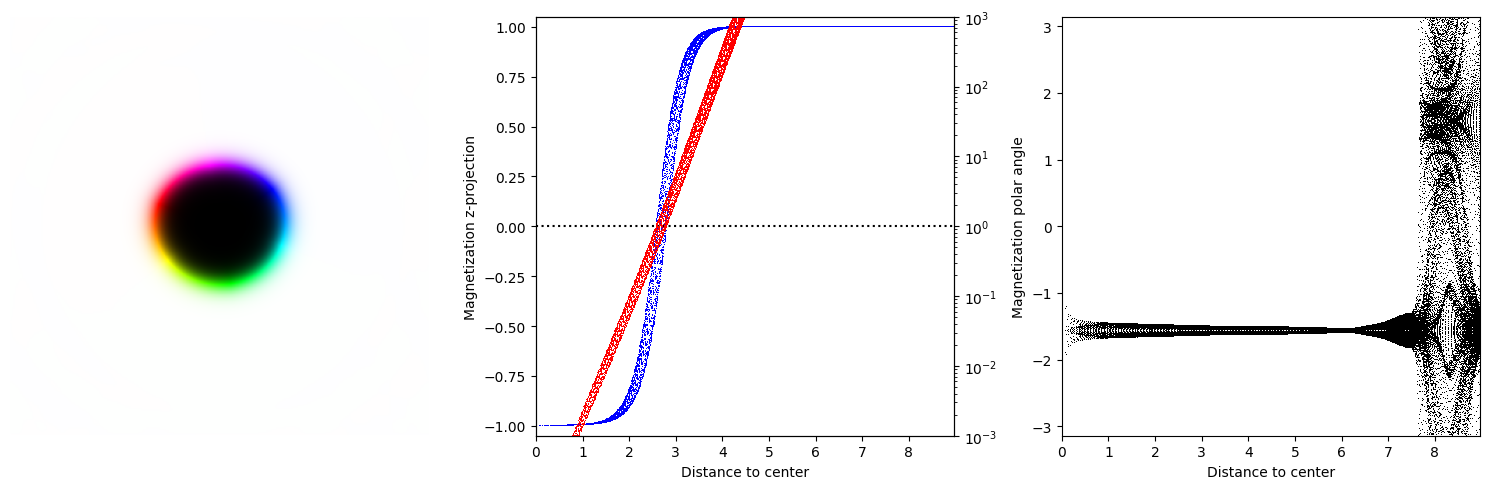

Output()

0: E 7.215 dE 2.15e-02 5.73e-04 Step 5.00e-02 Beta 0.00e+00 PE -1.28e-05 SubSteps 1 NegSteps 0 FailedConv 0

250: E 7.182 dE 1.18e-02 2.57e-04 Step 5.00e-02 Beta 0.00e+00 PE 1.30e-04 SubSteps 1 NegSteps 0 FailedConv 0

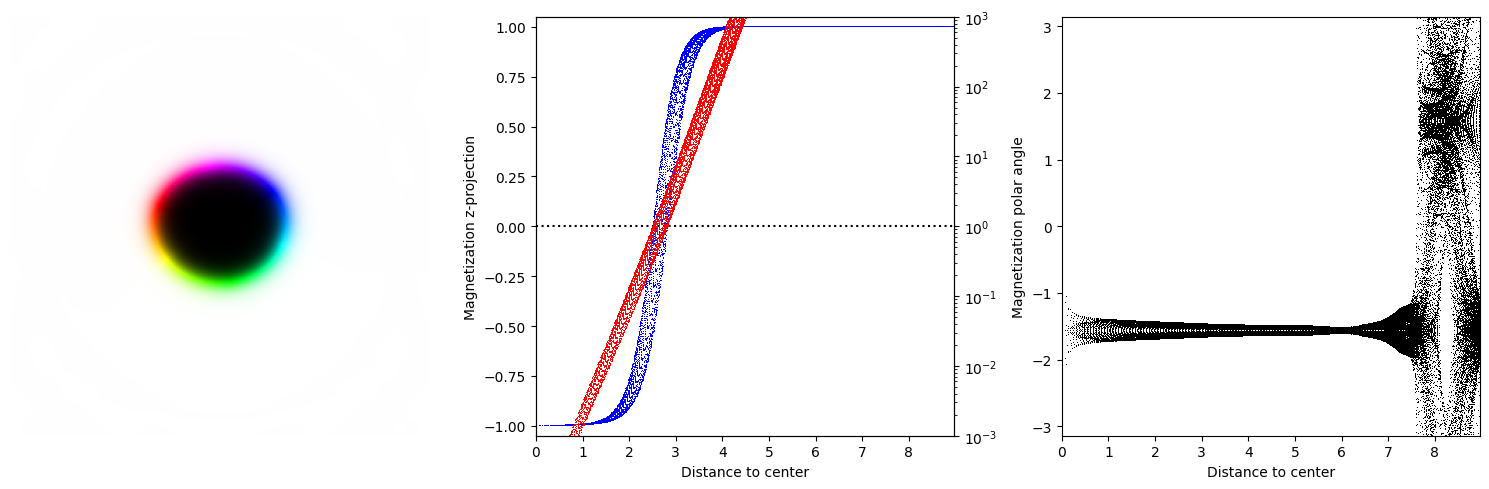

Output()

0: E 7.822 dE 2.61e-02 8.02e-04 Step 5.00e-02 Beta 0.00e+00 PE -1.50e-05 SubSteps 1 NegSteps 0 FailedConv 0

250: E 7.777 dE 1.40e-02 2.93e-04 Step 5.00e-02 Beta 0.00e+00 PE 1.84e-04 SubSteps 1 NegSteps 0 FailedConv 0

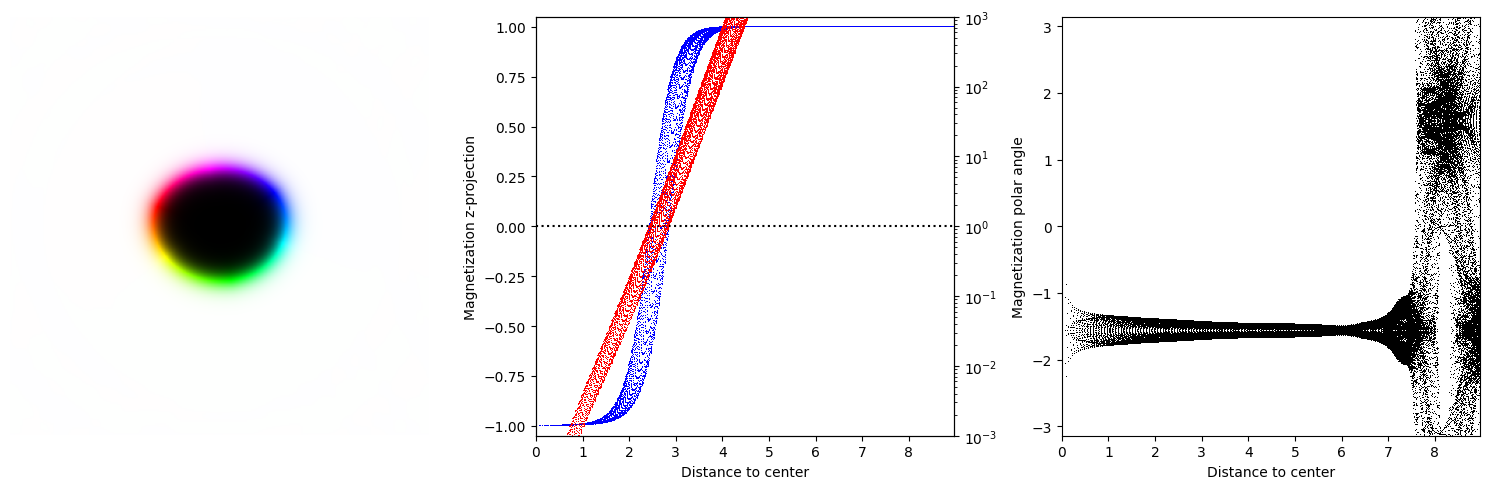

Output()

0: E 8.445 dE 3.56e-02 1.01e-03 Step 5.00e-02 Beta 0.00e+00 PE -1.69e-05 SubSteps 1 NegSteps 0 FailedConv 0

250: E 8.388 dE 1.58e-02 3.22e-04 Step 5.00e-02 Beta 0.00e+00 PE 2.32e-04 SubSteps 1 NegSteps 0 FailedConv 0

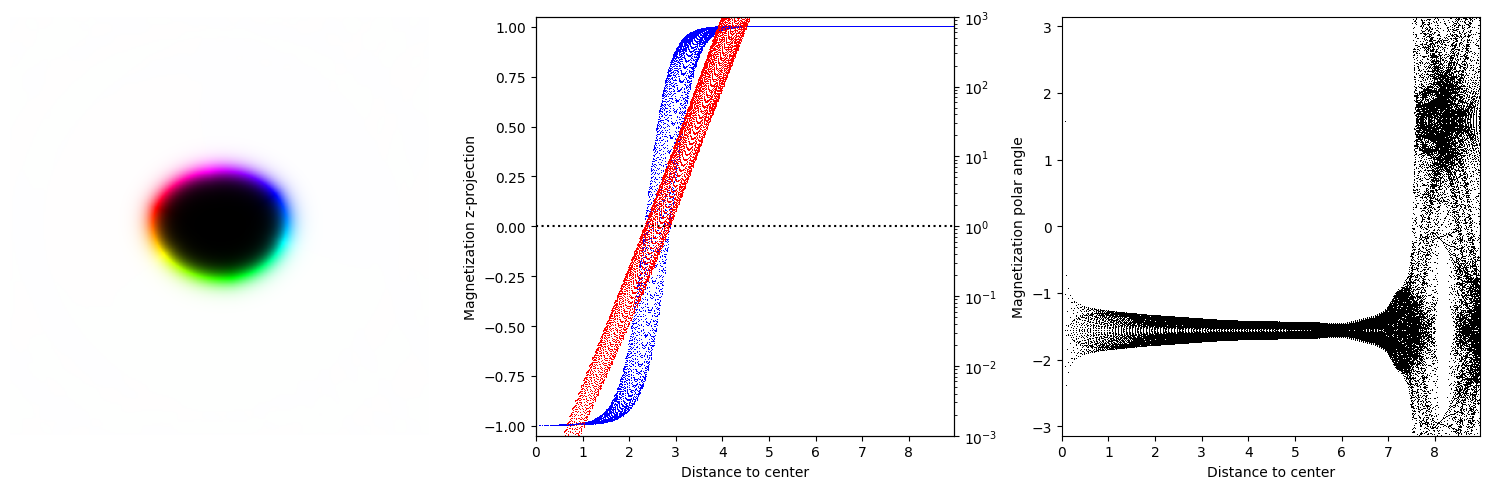

In [11]:
n2 = n
rxs = np.linspace(0, 0.5, 10)

ens = np.empty_like(rxs)
grads = np.empty_like(rxs)
for k, rx in enumerate(rxs):
    comp.system = jdc.replace(comp.system, J=-1., roll_x=rx)
    n2 = mg.ncg(n2, comp, maxiter=500, tol=1e-4, maxstep=0.05, nrep=2, constraints=mg.constrain_translations)
    mg.analyze_geometry(n2, xy, var=None); plt.show()
    ens[k], de = comp.v_d_energy(n2)
    de = mg.grad_normalize(de, n2)
    de = mg.constrain_translations(comp, de, n2)
    grads[k] = jnp.linalg.norm(de.flatten(),ord=np.inf)

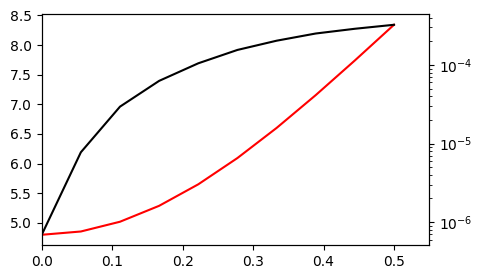

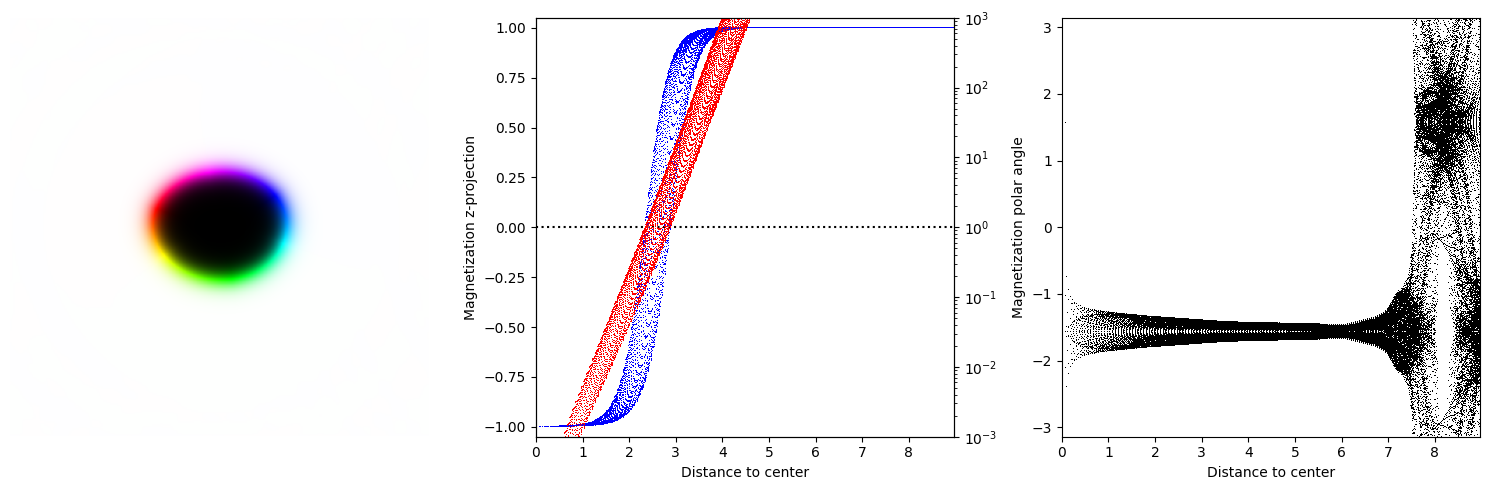

In [12]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(rxs, ens, '-r')
ax.plot(-rxs, ens, '-b')
ax.set_xlim(0,None);
bx = ax.twinx()
bx.semilogy(rxs, grads, '-k')

mg.analyze_geometry(n2, xy, var=None);
